In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
dataset_path='/content/gdrive/My Drive/minor/datasets/'
model_path='/content/gdrive/My Drive/minor/models/'


Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from nltk.stem import SnowballStemmer
from sklearn.utils import class_weight

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

,label,review
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df = pd.read_csv(dataset_path+'/formatted/YelpNYC_1.csv')
df.head()

,review,label
0,"Hearty, no messing, Italian fare. Had a. Great...",1
1,"You want Italian, and I mean homemade italian,...",1
2,FINALLY FINALLY FINALLY I found a great brick ...,1
3,I was so happy to find this gem! The restauran...,1
4,Can't say much that isnt said in the over 2000...,1


In [ ]:
df['label'].value_counts()

1    322097
0     36860
Name: label, dtype: int64

In [ ]:
fake_df = df[df['label']==0]
replicated_df = pd.concat([fake_df]*7,ignore_index=True)
replicated_df = replicated_df.sample(frac=1)
replicated_df.describe()
bal_df = pd.concat([replicated_df,df],ignore_index=True).sample(frac=1)
bal_df['label'].value_counts()

1    322097
0    294880
Name: label, dtype: int64

In [ ]:
regex_tokenizer = nltk.RegexpTokenizer(r"[^_\W]+")
english_stopwords = set(stopwords.words('english'))
def clean(dataframe):
  reviews=[]
  labels=[]
  for index,row in tqdm(dataframe.iterrows(),total=len(dataframe)):
      review,label = row['review'],row['label']
      review = review.lower()
      words = regex_tokenizer.tokenize(review)
      words = list(filter(lambda word: word not in english_stopwords , words))
      reviews.append(' '.join(words))
      labels.append(label)
  return pd.DataFrame({'review':reviews,'label':labels})

In [ ]:
cdf = clean(bal_df)
cdf.head()

100%|██████████| 616977/616977 [01:19<00:00, 7735.79it/s]


,review,label
0,one favorites great food ambiance service,0
1,place unbelievable true authentic mediterranea...,0
2,pleasant experience indeed guy friend came fir...,0
3,best crostini face planet could eat everyday,0
4,think place trying sort like combo sweatleaf i...,1


In [ ]:
train,test = train_test_split(cdf,test_size=0.3)
print("Train :\n",train['label'].value_counts(),"\nTest :\n", test['label'].value_counts())

Train :
 1    225435
0    206448
Name: label, dtype: int64 
Test :
 1    96662
0    88432
Name: label, dtype: int64


In [ ]:
embedding_dim = 100
reviews = []
labels=[]
for index,row in tqdm(train.iterrows(),total=len(train)):
  reviews.append(row['review'].split(' '))
  labels.append(row['label'])
print(train.head())

100%|██████████| 431883/431883 [00:37<00:00, 11455.08it/s]

                                                   review  label
216353      save time money go bodega buy gallon oil chug      1
611939  food disappointing foie gras texture bit grain...      1
435148  hostess rude waitress come often although food...      0
527167  times food fine service absolutly nothing spec...      0
176380  eat one word kangaroo service point decor ador...      1


In [ ]:
train_df = train

In [ ]:
word2vec_model = Word2Vec(
    reviews,
    window=5,
    min_count=10,
    size=embedding_dim,
    sg=1,
    compute_loss=True
)

In [ ]:
embedding_matrix = np.load(model_path+'embedding_matrix.npy')
vocab_size=embedding_matrix.shape[0]

In [ ]:
# vocab_size = len(word2vec_model.wv.vocab)+1
texts = [' '.join(sentance) for sentance in reviews]

In [ ]:
vocabulary_tokenizer = Tokenizer(num_words= vocab_size)
vocabulary_tokenizer.fit_on_texts(texts)

In [ ]:
len(vocabulary_tokenizer.word_index),vocab_size

(110152, 31374)

In [ ]:
import pickle

# saving
with open(model_path+'tokenizer.pickle', 'wb') as handle:
    pickle.dump(vocabulary_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:

# loading
with open(model_path+'tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

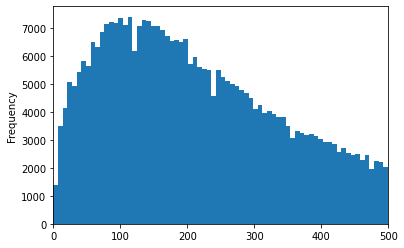

In [ ]:
length=[]
for text in texts:
  length.append(len(text))
length = np.array(length)
len_df = pd.DataFrame({'len':length})
len_df['len'].plot.hist(xlim=(0,500),bins=800)

In [ ]:
sequences = vocabulary_tokenizer.texts_to_sequences(texts)
preprocessed_data = pad_sequences(sequences,padding='post',maxlen=300)

In [ ]:
embedding_matrix = np.zeros([vocab_size,embedding_dim])
for word, index in vocabulary_tokenizer.word_index.items():
    if index > vocab_size:
        break
    else:
      try:
        embedding = word2vec_model.wv.__getitem__(word)
        if embedding is not None:
          embedding_matrix[index] = embedding
      
      except:
        print(word,' not in vocab')
        pass
      

dece  not in vocab
beause  not in vocab


In [ ]:
np.save("/content/gdrive/My Drive/minor/full_embedding_matrix.npy",embedding_matrix)

In [ ]:
embedding_matrix.shape

(31398, 100)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Flatten, GlobalAveragePooling1D
from keras.layers.embeddings import Embedding
from tensorflow.keras.metrics import Precision, Recall


In [ ]:
model = Sequential()
model.add(Embedding(
        vocab_size,
        embedding_dim,
        input_length=preprocessed_data.shape[1],
        weights=[embedding_matrix],
        trainable=False
    ))

In [ ]:
tr = np.array([preprocessed_data[0]]).reshape(1,300)
pr=model.predict(tr)
pr[0]

array([[-0.01673118,  0.22587611,  0.24018362, ...,  0.08449297,
        -0.09423019,  0.20281987],
       [-0.172545  ,  0.08351269,  0.39916617, ..., -0.2022504 ,
         0.03856146, -0.06490614],
       [-0.45716292, -0.53706557,  0.3825397 , ...,  0.03265129,
        -0.2612426 ,  0.37708083],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [ ]:
embedding_matrix[preprocessed_data[0][0]]

array([-0.01673118,  0.22587611,  0.24018362,  0.26144513,  0.28515974,
       -0.22089688,  0.08501896,  0.01136673,  0.01401406,  0.24100496,
        0.28529418,  0.42856589,  0.06661099,  0.2775799 , -0.09756193,
       -0.35553131, -0.06170885, -0.21256505, -0.12761185,  0.12392813,
       -0.09499884,  0.36558366,  0.3237938 , -0.6592288 ,  0.26053113,
        0.1276392 ,  0.46011272,  0.54502344, -0.08210994,  0.06332767,
        0.26563108, -0.16357368,  0.61031103,  0.27942529,  0.3158555 ,
       -0.17161539,  0.27342334,  0.05842378, -0.07692351,  0.45842868,
       -0.5925529 ,  0.47288921,  0.30448359,  0.26602796, -0.07706647,
       -0.10305639,  0.05766195,  0.25030422,  0.41912708,  0.06006414,
        0.07768683, -0.12304123,  0.81617457, -0.7818796 ,  0.5307157 ,
       -0.53584355, -0.07117236,  0.5342288 ,  0.3697024 , -0.27447626,
        0.1361654 , -0.20486212,  0.63219577,  0.22927187, -0.64812273,
        0.03761626, -0.06658813,  0.03731691,  0.1659669 ,  0.07

In [ ]:
def create_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocab_size, embedding_dim, input_length=preprocessed_data.shape[1],weights=[embedding_matrix], trainable=False))
    model_conv.add(Conv1D(32, 5, activation='relu'))
    model_conv.add(LSTM(32))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy',Precision(),Recall()])
    return model_conv
model = create_model()
model.summary()
model.fit(preprocessed_data, np.array(labels), batch_size=200 ,validation_split=0.3,epochs = 20)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          3139800   
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 32)           16032     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 3,164,185
Trainable params: 24,385
Non-trainable params: 3,139,800
_________________________________________________________________
Epoch 1/20
1512/1512 [==============================] - 653s 432ms/step - loss: 0.6878 - accuracy: 0.5349 - precision: 0.5309 - recall: 0.9317 - val_loss: 0.6915 - val_accuracy: 0.5306 - val_precision: 0.5265 - val_recall: 0.9917
Epoch 2

In [ ]:
model.fit(preprocessed_data, np.array(labels), batch_size=200 ,validation_split=0.3,epochs = 30,initial_epoch=20)

Epoch 21/30
1512/1512 [==============================] - 664s 439ms/step - loss: 0.4900 - accuracy: 0.7660 - precision: 0.8623 - recall: 0.6562 - val_loss: 0.5322 - val_accuracy: 0.7381 - val_precision: 0.7921 - val_recall: 0.6749
Epoch 22/30
1512/1512 [==============================] - 665s 440ms/step - loss: 0.4849 - accuracy: 0.7702 - precision: 0.8693 - recall: 0.6587 - val_loss: 0.5311 - val_accuracy: 0.7393 - val_precision: 0.8375 - val_recall: 0.6204
Epoch 23/30
1512/1512 [==============================] - 673s 445ms/step - loss: 0.4831 - accuracy: 0.7717 - precision: 0.8747 - recall: 0.6564 - val_loss: 0.5422 - val_accuracy: 0.7356 - val_precision: 0.7779 - val_recall: 0.6900
Epoch 24/30
1512/1512 [==============================] - 675s 446ms/step - loss: 0.4821 - accuracy: 0.7735 - precision: 0.8792 - recall: 0.6560 - val_loss: 0.5241 - val_accuracy: 0.7477 - val_precision: 0.8562 - val_recall: 0.6202
Epoch 25/30
1512/1512 [==============================] - 679s 449ms/step - l

In [ ]:
model.fit(preprocessed_data, np.array(labels), batch_size=200 ,validation_split=0.3,epochs = 40,initial_epoch=30)

Epoch 31/40
1512/1512 [==============================] - 684s 452ms/step - loss: 0.4510 - accuracy: 0.7980 - precision: 0.9065 - recall: 0.6832 - val_loss: 0.5032 - val_accuracy: 0.7648 - val_precision: 0.8641 - val_recall: 0.6514
Epoch 32/40
1512/1512 [==============================] - 669s 442ms/step - loss: 0.4432 - accuracy: 0.8024 - precision: 0.9123 - recall: 0.6873 - val_loss: 0.5150 - val_accuracy: 0.7554 - val_precision: 0.9105 - val_recall: 0.5888
Epoch 33/40
1512/1512 [==============================] - 668s 442ms/step - loss: 0.4379 - accuracy: 0.8060 - precision: 0.9165 - recall: 0.6910 - val_loss: 0.5017 - val_accuracy: 0.7646 - val_precision: 0.8764 - val_recall: 0.6387
Epoch 34/40
1512/1512 [==============================] - 673s 445ms/step - loss: 0.4358 - accuracy: 0.8079 - precision: 0.9165 - recall: 0.6950 - val_loss: 0.5171 - val_accuracy: 0.7548 - val_precision: 0.8663 - val_recall: 0.6263
Epoch 35/40
1512/1512 [==============================] - 670s 443ms/step - l

In [ ]:
model.fit(preprocessed_data, np.array(labels), batch_size=200 ,validation_split=0.3,epochs = 50,initial_epoch=40)

Epoch 41/50
1512/1512 [==============================] - 678s 448ms/step - loss: 0.4428 - accuracy: 0.8031 - precision: 0.9134 - recall: 0.6877 - val_loss: 0.5183 - val_accuracy: 0.7529 - val_precision: 0.9163 - val_recall: 0.5790
Epoch 42/50
1512/1512 [==============================] - 675s 446ms/step - loss: 0.4342 - accuracy: 0.8096 - precision: 0.9219 - recall: 0.6939 - val_loss: 0.4978 - val_accuracy: 0.7720 - val_precision: 0.8778 - val_recall: 0.6536
Epoch 43/50
1512/1512 [==============================] - 675s 447ms/step - loss: 0.4342 - accuracy: 0.8092 - precision: 0.9295 - recall: 0.6862 - val_loss: 0.5051 - val_accuracy: 0.7656 - val_precision: 0.8920 - val_recall: 0.6263
Epoch 44/50
1512/1512 [==============================] - 669s 442ms/step - loss: 0.4333 - accuracy: 0.8102 - precision: 0.9292 - recall: 0.6888 - val_loss: 0.5291 - val_accuracy: 0.7452 - val_precision: 0.9218 - val_recall: 0.5587
Epoch 45/50
1512/1512 [==============================] - 673s 445ms/step - l

KeyboardInterrupt: ignored

In [ ]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/minor/full_balanced_modelA76_epoch30.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/My Drive/full_balanced_modelA76_epoch30.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
test_seq = vocabulary_tokenizer.texts_to_sequences(test['review'])
test_data = pad_sequences(test_seq,padding='post',maxlen=300)

In [ ]:
np.save(dataset_path+'X_test.npy',test_data)
np.save(dataset_path+'X_train.npy',preprocessed_data)
np.save(dataset_path+'y_test.npy',np.array(test['label']))
np.save(dataset_path+'y_train.npy', np.array(labels))


In [ ]:
model.evaluate(test_data,test['label'])

5785/5785 [==============================] - 193s 33ms/step - loss: 0.5052 - accuracy: 0.7658 - precision: 0.8787 - recall: 0.6408


[0.5052070021629333, 0.765848696231842, 0.8787093162536621, 0.6407817006111145]

In [ ]:
from sklearn.metrics import confusion_matrix
p=model.predict(test_data)
confusion_matrix(test['label'],p.round())

array([[79718,  8563],
       [34777, 62036]])

After 50 epochs

In [ ]:
model.evaluate(test_data,test['label'])

648/648 [==============================] - 84s 129ms/step - loss: 0.5541 - accuracy: 0.7072 - precision: 0.9343 - recall: 0.4717


[0.5540655255317688, 0.7072048783302307, 0.934265673160553, 0.4716618061065674]

In [ ]:
from sklearn.metrics import confusion_matrix
p=model.predict(test_data)
confusion_matrix(test['label'],p.round())

array([[84801,  3480],
       [50419, 46394]])

# Model suggested in Papers

In [ ]:
def create_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocab_size, embedding_dim, input_length=preprocessed_data.shape[1], weights=[embedding_matrix], trainable=False))
    model_conv.add(Conv1D(100, 5, activation='relu'))
    model_conv.add(Conv1D(100, 5, activation='relu'))
    model_conv.add(Conv1D(40, 5, activation='relu'))
    model_conv.add(Flatten())
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',Precision(),Recall()])
    return model_conv
model = create_model()
model.summary()
history = model.fit(preprocessed_data, np.array(labels), batch_size=1000 ,validation_split=0.3,epochs = 15)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 100)          3139800   
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 296, 100)          50100     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 292, 100)          50100     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 288, 40)           20040     
_________________________________________________________________
flatten_7 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11521     
Total params: 3,271,561
Trainable params: 131,761
Non-trainable params: 3,139,800
______________________________________

In [ ]:

test_seq = vocabulary_tokenizer.texts_to_sequences(test['review'])
test_data = pad_sequences(test_seq,padding='post',maxlen=300)


In [ ]:
model.evaluate(test_data,test['label'])

5785/5785 [==============================] - 25s 4ms/step - loss: 0.4114 - accuracy: 0.8955 - precision_23: 0.9708 - recall_23: 0.8243


[0.41141387820243835,
 0.8954639434814453,
 0.9707573056221008,
 0.8243066668510437]

In [ ]:
from sklearn.metrics import confusion_matrix
p=model.predict(test_data)
confusion_matrix(test['label'],p.round())

array([[86206,  2396],
       [16953, 79539]])

In [ ]:
X_test = np.load(dataset_path+'X_test.npy')
y_test = np.load(dataset_path+'y_test.npy')

In [ ]:
model.evaluate(X_test,y_test)

5785/5785 [==============================] - 25s 4ms/step - loss: 0.5275 - accuracy: 0.9162 - precision_23: 0.9768 - recall_23: 0.8597


[0.5274617075920105,
 0.9162371754646301,
 0.9768487811088562,
 0.8596982359886169]

In [ ]:
np.save(dataset_path+'X_test.npy',test_data)
np.save(dataset_path+'y_test.npy',test['label'])
np.save(dataset_path+'X_train.npy',preprocessed_data)
np.save(dataset_path+'y_train.npy', np.array(labels))


In [ ]:
model_json = model.to_json()
with open(model_path+"modelA91.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(model_path+"modelA91.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from keras.models import model_from_json
json_file = open(model_path+'modelA91.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_path+"modelA91.h5")

loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',Precision(),Recall()])
loaded_model.summary()
print("Loaded model from disk")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 100)          3139800   
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 296, 100)          50100     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 292, 100)          50100     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 288, 40)           20040     
_________________________________________________________________
flatten_7 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11521     
Total params: 3,271,561
Trainable params: 131,761
Non-trainable params: 3,139,800
______________________________________

In [ ]:
loaded_model.evaluate(X_test,y_test)

5785/5785 [==============================] - 23s 4ms/step - loss: 0.5275 - accuracy: 0.9162 - precision_1: 0.9768 - recall_1: 0.8597


[0.5274617075920105,
 0.9162371754646301,
 0.9768487811088562,
 0.8596982359886169]

In [ ]:
with open(model_path+'tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
s = tokenizer.texts_to_sequences(["Amazing sounds clarity Pros : good bass on fu volume , you'll get a feeling that your ear are vibrating, Vocals and mids are superb.Cons, no volume controls"])
d = pad_sequences(s,padding="post",maxlen=300)
loaded_model.predict(d)

# for i,j in test.iterrows():
#   if(j['label']==0):
#     print(j['review'])
#     break

array([[1.]], dtype=float32)

# K-fold cross validation (k=5)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
dataset_path = '/content/gdrive/My Drive/minor/datasets/'
model_path = '/content/gdrive/My Drive/minor/models/'
X_train = np.array(np.load(dataset_path+'X_train.npy'))
y_train =np.array(np.load(dataset_path+'y_train.npy'))
X_test = np.array(np.load(dataset_path+'X_test.npy'))
y_test = np.array(np.load(dataset_path+'y_test.npy'))

embedding_matrix = np.load(model_path+'embedding_matrix.npy')
vocab_size = embedding_matrix.shape[0]
input_embedding_length = X_train.shape[1]
embedding_dim = embedding_matrix.shape[1]

vocab_size,input_embedding_length,embedding_dim,len(X_train)

(31374, 300, 100, 431883)

In [ ]:
X_train.shape

(431883, 300)

In [ ]:
k=5
kfold = StratifiedKFold(k,shuffle=True,random_state=12)
acc_per_fold = []
prec_per_fold=[]
recall_per_fold=[]
histories=[]
loss_per_fold = []
fold=1

for train, test in kfold.split(preprocessed_data,np.array(labels)):
  print(f"Fold {fold} ")
  _, counts = np.unique(y_train, return_counts=True)
  print('deceptive/genuine : ',float(counts[0]/len(train)))
  def create_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocab_size, embedding_dim, input_length=300, weights=[embedding_matrix], trainable=False))
    model_conv.add(Conv1D(100, 5, activation='relu'))
    model_conv.add(Conv1D(100, 5, activation='relu'))
    model_conv.add(Conv1D(40, 5, activation='relu'))
    model_conv.add(Flatten())
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',Precision(),Recall()])
    return model_conv
  model = create_model()
  history = model.fit(preprocessed_data[train], np.array(labels)[train], batch_size=1000 ,validation_split=0.2, epochs = 25)
  y_pred = model.predict(preprocessed_data[test])
  scores = model.evaluate(preprocessed_data[test], np.array(labels)[test])
  cm = confusion_matrix(np.array(labels)[test],y_pred.round())
  acc_per_fold.append(scores[1])
  prec_per_fold.append(scores[2])
  recall_per_fold.append(scores[3])
  histories.append(history)
  print(f'Score for fold {fold}: {model.metrics_names[0]}={scores[0]}; {model.metrics_names[1]}={scores[1]}; {model.metrics_names[2]}={scores[2]}; {model.metrics_names[3]}={scores[3]}')
  print(cm,'\n\n\n')
  fold += 1


Fold 1 
deceptive/genuine :  0.5970316000301008
Epoch 1/25
277/277 [==============================] - 25s 90ms/step - loss: 0.6480 - accuracy: 0.6192 - precision_8: 0.6382 - recall_8: 0.6273 - val_loss: 0.6318 - val_accuracy: 0.6369 - val_precision_8: 0.6496 - val_recall_8: 0.6580
Epoch 2/25
277/277 [==============================] - 24s 88ms/step - loss: 0.6060 - accuracy: 0.6659 - precision_8: 0.6849 - recall_8: 0.6687 - val_loss: 0.5900 - val_accuracy: 0.6762 - val_precision_8: 0.6662 - val_recall_8: 0.7584
Epoch 3/25
277/277 [==============================] - 24s 88ms/step - loss: 0.5221 - accuracy: 0.7378 - precision_8: 0.7576 - recall_8: 0.7329 - val_loss: 0.5288 - val_accuracy: 0.7357 - val_precision_8: 0.7813 - val_recall_8: 0.6843
Epoch 4/25
277/277 [==============================] - 24s 88ms/step - loss: 0.4334 - accuracy: 0.8000 - precision_8: 0.8243 - recall_8: 0.7849 - val_loss: 0.4931 - val_accuracy: 0.7601 - val_precision_8: 0.7469 - val_recall_8: 0.8161
Epoch 5/25
277/2

In [ ]:
from matplotlib import pyplot as plt
for history in histories:
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val','loss','val_loss'], loc='upper left')
  plt.show()

In [ ]:
embedding_layer = Embedding(vocabulary_size, embedding_dim,input_length=input_embedding_length, weights=[embedding_matrix],trainable=False)

In [ ]:
import tensorflow as tf
import datetime
import os
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
 from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(embedding_layer)
    model_conv.add(Conv1D(100, 5, activation='relu'))
    model_conv.add(Conv1D(100, 5, activation='relu'))
    model_conv.add(Conv1D(40, 5, activation='relu'))
    model_conv.add(Flatten())
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',Precision(),Recall()])
    return model_conv

model_bd = create_conv_model()
model_bd.summary()
history = model_bd.fit(X_train, y_train, batch_size=500 ,validation_split=0.3, epochs = 30)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          3137400   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 296, 100)          50100     
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 292, 100)          50100     
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 288, 40)           20040     
_________________________________________________________________
flatten_6 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11521     
Total params: 3,269,161
Trainable params: 131,761
Non-trainable params: 3,137,400
______________________________________

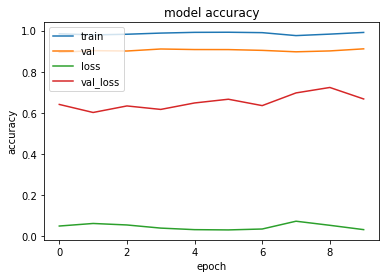

In [ ]:
from matplotlib import pyplot as plt
def graph(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val','loss','val_loss'], loc='upper left')
  plt.show()

In [ ]:
history = model.fit(preprocessed_data, np.array(labels), batch_size=1000 ,validation_split=0.3,epochs = 40,initial_epoch=30)

Epoch 31/40
303/303 [==============================] - 29s 95ms/step - loss: 0.0481 - accuracy: 0.9846 - precision_23: 0.9896 - recall_23: 0.9809 - val_loss: 0.6404 - val_accuracy: 0.8945 - val_precision_23: 0.9680 - val_recall_23: 0.8257
Epoch 32/40
303/303 [==============================] - 29s 95ms/step - loss: 0.0606 - accuracy: 0.9790 - precision_23: 0.9846 - recall_23: 0.9750 - val_loss: 0.6012 - val_accuracy: 0.9024 - val_precision_23: 0.9690 - val_recall_23: 0.8403
Epoch 33/40
303/303 [==============================] - 29s 94ms/step - loss: 0.0533 - accuracy: 0.9824 - precision_23: 0.9880 - recall_23: 0.9781 - val_loss: 0.6331 - val_accuracy: 0.9006 - val_precision_23: 0.9762 - val_recall_23: 0.8303
Epoch 34/40
303/303 [==============================] - 29s 94ms/step - loss: 0.0380 - accuracy: 0.9879 - precision_23: 0.9925 - recall_23: 0.9843 - val_loss: 0.6161 - val_accuracy: 0.9105 - val_precision_23: 0.9873 - val_recall_23: 0.8397
Epoch 35/40
303/303 [=======================

In [ ]:
model_bd.evaluate(X_test,y_test)

5785/5785 [==============================] - 25s 4ms/step - loss: 0.6587 - accuracy: 0.8687 - precision_19: 0.9635 - recall_19: 0.7778


[0.6587020754814148, 0.868650496006012, 0.9634549617767334, 0.7778214812278748]

In [ ]:
from sklearn.metrics import confusion_matrix
p=model_bd.predict(X_test)
confusion_matrix(y_test,p.round())

array([[85646,  2850],
       [21462, 75136]])

In [ ]:
from keras.models import model_from_json
json_file = open(model_path+'modelA90.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_path+"modelA90.h5")

loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',Precision(),Recall()])
loaded_model.summary()
print("Loaded model from disk")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 100)          3139800   
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 296, 100)          50100     
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 292, 100)          50100     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 288, 40)           20040     
_________________________________________________________________
flatten_7 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11521     
Total params: 3,271,561
Trainable params: 131,761
Non-trainable params: 3,139,800
______________________________________

In [ ]:
loaded_model.evaluate(X_test,y_test)

5785/5785 [==============================] - 25s 4ms/step - loss: 0.4114 - accuracy: 0.8955 - precision_25: 0.9708 - recall_25: 0.8243


[0.41141387820243835,
 0.8954639434814453,
 0.9707573056221008,
 0.8243066668510437]

In [ ]:
loaded_model.get_weights()